# Proyecto ML - Cleveland heart disease

297
target
0    160
1    137
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        32
           1       0.84      0.75      0.79        28

    accuracy                           0.82        60
   macro avg       0.82      0.81      0.81        60
weighted avg       0.82      0.82      0.82        60

Ruta absoluta donde se guardarán los modelos: /Users/beatrizcartiel/Desktop/src/models

🔍 Entrenando modelo: LogisticRegression
✅ Modelo LogisticRegression guardado en: ../models/LogisticRegression.joblib
¿El archivo existe? True
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        32
           1       0.84      0.75      0.79        28

    accuracy                           0.82        60
   macro avg       0.82      0.81      0.81        60
weighted avg       0.82      0.82      0.82        60


🔍 Entrenando modelo: RandomForest
✅ Modelo RandomForest guar

,Model,Accuracy,Precision,Recall,F1-Score
2,SVC,0.850,0.880,0.786,0.830
0,LogisticRegression,0.817,0.840,0.750,0.792
1,RandomForest,0.817,0.840,0.750,0.792
4,MLPClassifier,0.800,0.786,0.786,0.786
3,GradientBoosting,0.800,0.808,0.750,0.778


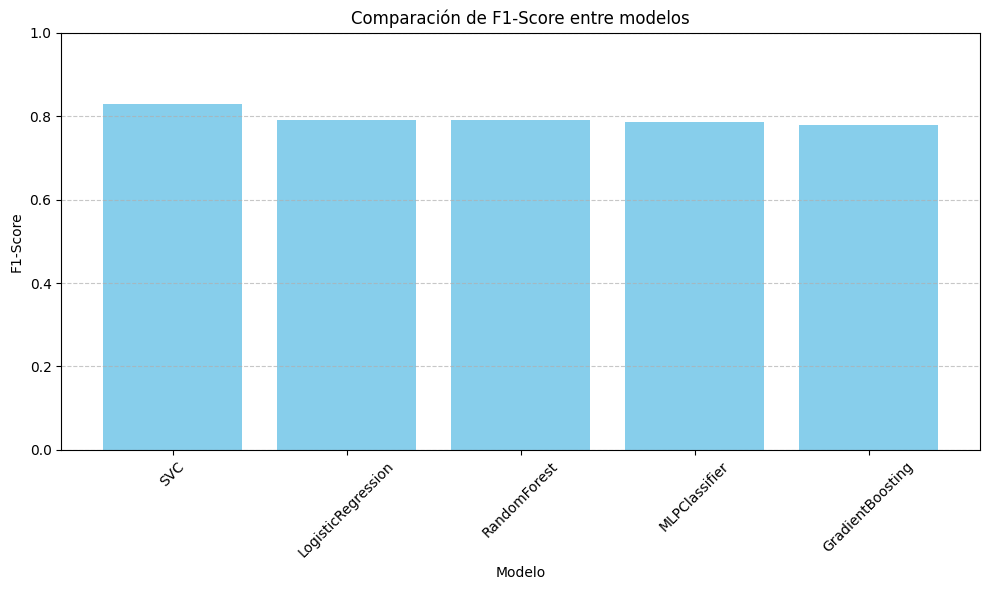

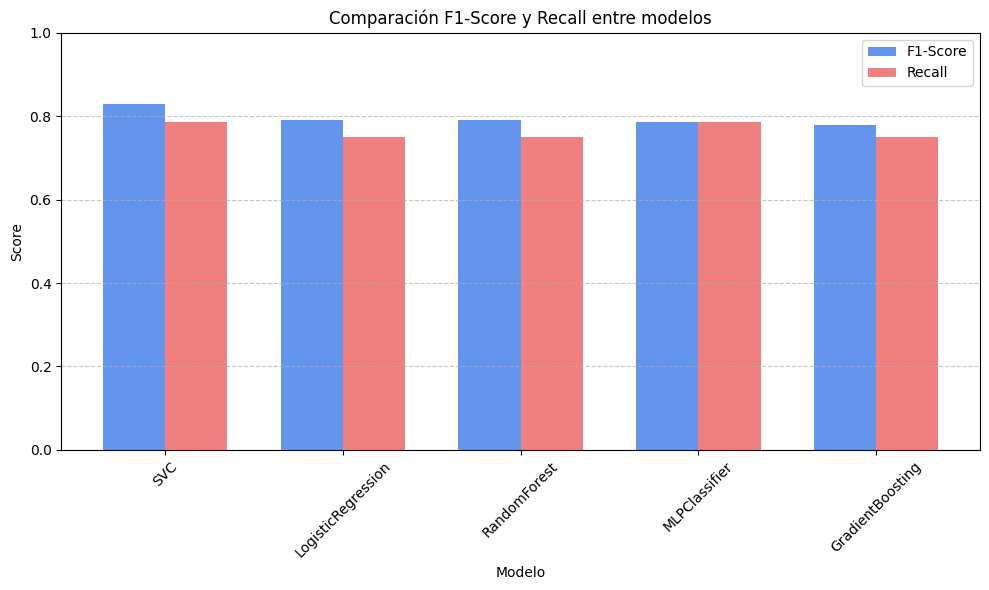

In [1]:
import pandas as pd
import os
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import seaborn as sns


# Obtener la ruta absoluta del directorio raíz del proyecto
ruta_proyecto = os.path.abspath(os.path.join(os.getcwd(), "../"))

# Construir la ruta al dataset
ruta_csv = os.path.join(ruta_proyecto, "data_sample/cleveland_heart_disease.csv")

# Cargar el dataset
column_names = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
                "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]
df = pd.read_csv(ruta_csv, names=column_names)

# Asegurar que todos los valores son strings antes de reemplazar
df = df.map(lambda x: str(x).strip() if isinstance(x, str) else x)

# Reemplazar "?" por NaN
df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)
print(len(df))

# La convierto a clasificacion binaria
df["target"] = df["target"].apply(lambda x: 1 if x > 0 else 0)
print(df["target"].value_counts())

# Separar en variables predictoras (X) y target (y)
X = df.drop("target", axis=1)
y = df["target"]

# Dividir en conjunto de entrenamiento y prueba (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# 1. Separar columnas numéricas y categóricas
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# 1.1 Pipeline para variables numéricas: imputación + escalado
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 1.2 Pipeline para variables categóricas: imputación + codificación one-hot
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])


# 2. Pipelines de preprocesamiento: 
# 2.1 Pipeline para variables numéricas: imputación + escalado
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2.2 Pipeline para variables categóricas: imputación + codificación one-hot
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# 3. ColumnTransformer para aplicar el preprocesamiento según tipo de variable
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# 4. Pipeline final: preprocesamiento + modelo XGBClassifier
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

# 4. Búsqueda de hiperparámetros con GridSearchCV
# 4.1 Definición de la rejilla de hiperparámetros
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.05, 0.1]
}

# 4.2 Búsqueda con validación cruzada
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

# 5. Predicciones y evaluación
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))


# Ruta donde guardo los modelos
ruta_modelos = os.path.join("..", "models")
os.makedirs(ruta_modelos, exist_ok=True)
print("Ruta absoluta donde se guardarán los modelos:", os.path.abspath(ruta_modelos))


# Diccionario con los modelos a evaluar
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVC": SVC(kernel="rbf", probability=True),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "MLPClassifier": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

# Lista para guardar resultados
results = []

for model_name, model in models.items():
    print(f"\n🔍 Entrenando modelo: {model_name}")
    
    # Crear pipeline con preprocesamiento + modelo
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])
    
    # Entrenar
    pipeline.fit(X_train, y_train)
    
    # Predecir
    y_pred = pipeline.predict(X_test)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Guardar métricas
    results.append({
        "Model": model_name,
        "Accuracy": round(accuracy, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1-Score": round(f1, 3)
    })

    # Guardar modelo en src/models correctamente
    path_modelo = os.path.join(ruta_modelos, f"{model_name}.joblib")
    joblib.dump(pipeline, path_modelo)
    print(f"✅ Modelo {model_name} guardado en: {path_modelo}")
    print("¿El archivo existe?", os.path.isfile(path_modelo))
    print(classification_report(y_test, y_pred))

# Mostrar tabla comparativa
df_results = pd.DataFrame(results).sort_values(by="F1-Score", ascending=False)

print("\n📈 Comparativa de modelos (ordenados por F1-Score):")
display(df_results)


# Gráfico general: F1-Score de todos los modelos
plt.figure(figsize=(10, 6))
plt.bar(df_results["Model"], df_results["F1-Score"], color='skyblue')
plt.title("Comparación de F1-Score entre modelos")
plt.ylabel("F1-Score")
plt.xlabel("Modelo")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Gráfico comparativo: F1-Score y Recall lado a lado
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(df_results))

plt.bar(index, df_results["F1-Score"], bar_width, label="F1-Score", color="cornflowerblue")
plt.bar([i + bar_width for i in index], df_results["Recall"], bar_width, label="Recall", color="lightcoral")

plt.xlabel("Modelo")
plt.ylabel("Score")
plt.title("Comparación F1-Score y Recall entre modelos")
plt.xticks([i + bar_width / 2 for i in index], df_results["Model"], rotation=45)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
